## Computational Perception Assignment 1 {-}
Feb 4, 2019

### Q1. Signal Detection Theory (25 points) {-}

Assume you measure a signal plus Gaussian noise: $y = x + n$, where $n \sim N(0, \sigma_n)$.

Imports and utility functions:

In [68]:
import matplotlib.pyplot as plt
import numpy as np

In [133]:
def plot_function(f, min=0, max=2, step_size=101):
    x = np.linspace(min, max, step_size)
    y = f(x)
    plt.plot(x, y)


def show_graph():
    plt.grid()
    plt.show()


def add_signals(sig_a, sig_b):
    return lambda a: sig_a(a) + sig_b(a)

1.1 Calculate and plot the optimal detection threshold overlaid on the distributions of $n$ and $y$. (5 pts)

The distribution function for a constant signal is degenerate, infinite at its value x and 0 everywhere else.  Since that doesn't graph well, here I just set its value in the plot to 10 as an approximation. The optimal detection threshold, when P(observed|x) = P(observed|n)

the below doesn't make sense because we can't just know for sure, even if it is just a constant tone, what is wrong with my reasoning here? P(observed|x) = P(observed|n) when integral of noise distribution up to threshold = integral of signal distribution up

Also, since x's distribution's value is infinity at x and 0 everywhere else, it is guaranteed to be arbitrarily higher amplitude at that one point than the normal distribution of noise (excluding the case when the noise distribution's mean is x and variance is 0, in which case the signal and noise distributions are exactly the same and thus indistinguishable).  Therefore, the optimal detection threshold is arbitrarily close to x, which we can easily find as it is the peak amplitude of the signal.  

In [136]:
def constant_signal_distribution(x):
    # set value of pdf at x to 1
    return lambda a: [(x == ai) * 10 for ai in a]


def gaussian_noise_distribution(mu, sigma):
    return lambda a: np.exp(-(a - mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

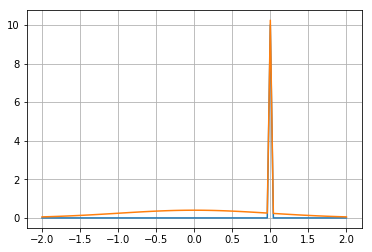

In [146]:
plot_function(constant_signal_distribution(1), min=-2, max=2)
plot_function(add_signals(gaussian_noise_distribution(0, 1), constant_signal_distribution(1)), min=-2, max=2)
show_graph()

Generalize this model so that the signal itself is variable, i.e. $x \sim N(\mu_x, \sigma_x)$.  

1.2 Derive the distribution of $y$. (5 pts)

1.3 Derive the optimal threshold under this model.  State any assumptions you make. (5 pts) 

1.4 What are the expressions for the probability of a successful detection (a true positive) and of a false alarm (a false positive)? (5 pts)

1.5 Code a functions to calculate these, and use them to plot the ROC curves for different SNRs. Follow the format in Dusenbery-fig.5.2. You should use a toolbox or package that defines common distributions and a cdf function. (5 pts)

### Q2. Detection in a time-varying signal (15 points) {-}

Now assume your signals are time-varying: $y(t) = x(t) + n(t)$.  Assume again Gaussian noise, $y(t) \sim N(0, \sigma_n)$, and for simplicity, that $t$ is discrete and the measured samples $y(t)$ are independent.  The signal $x(t)$, however, only arrives at random intervals and is zero elsewhere.  Events that arrive at random, independent invervals obey Poisson statistics, and the interval can be modeled with an exponential distribution.

2.1 Write code to generate signals from this model. (5 pts)

2.2 Derive the optimal threshold detector for this scenario.  Be sure to consider the probability of the signal being present in any particular sample.  Contrast this with the threshold in Q1. (5 pts)

2.3 Write code to plot your generated signal and illustrate threshold detection with a roughly 95% true positive rate. (5 pts)


### Q3. Spectra and Spectrograms (15 points) {-}

3.1 Read the bach.wav file and plot its Fourier spectrum. (5 pts)

3.2 Plot the spectrogram (i.e. the time-varying spectrum).  Choose a time interval, windowing, and other parameters such that the individual notes and their harmonics are clearly visible.  Be sure to explain your choices. (5 pts)

3.3 Plot the spectrogram of the first note. Follow the format in AN-fig.1.4.  This note is called $E_5$, which is the E above middle C, and in common tunings has a pitch of 659 Hz.  Show that this note roughly matches this frequency. (5 pts)

### Q4. Filtering (25 points) {-}

4.1 Write a function to calcuate discrete convolution $y(t) = h(t) * x(t)$.  For pedagogical purposes, do this "by hand", i.e. with for loops, and do not use a built-in function. (5 pts)

4.2. Write code to define a low-pass filter.  A simple low-pass filter is a Gaussian with a width defined in samples.  Convolving this will take a weighted average of the samples around $x(t)$. (5 pts)

4.3. Apply your filter to bach.wav.  Illustrate and explain what you did. (5 pts)

4.4. Write a function for a Gaussian-modulated sine wave.  It should take as parameters, frequency (in Hz), width (in samples), and standard deviation (in secs). (5 pts)

4.5 Use your above function to make a "matched" filter for the first note.  Convolve this filter with bach.wav and illustrate the extent to which this simplistic scheme is able to detect occurences of the note $E_5$ in the audio.  For reference, the music, with the $E_5$ notes circled in red is below.  The audio goes a little beyond what is show, but the note doesn't occur there. (5 pts)

![bach.wav music](bach-music.png)

### Q5. Questions about the Readings (10 points) {-}

5.1 Summarize the evidence that we can detect single photons. (5 pts)

5.2 Summarize the evidence that the some animals can detect sounds that result in *subatomic* vibrations of their eardrum. (5 pts)

### Q6. Exploration (10 points) {-}

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here is the grading rubric:

- Was the topic clearly described and concise? (3 pts)

- Were the relevant concepts clearly explained? (3 pts)

- Did the problem go beyond or is distinct from what was already convered in the questions above? (4 pts)